In [97]:
import tensorflow as tf
import tensorflow_hub as hub


# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time

import ijson

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.3.0
The following GPU devices are available: 


In [98]:
# Load label file for Coco17
json_file = '../Data/instances_val2017.json'
coco_labels = dict()
with open(json_file,'r') as fd:
    objs = ijson.items(fd, 'categories.item')
    t_labels = [o for o in objs]
    count = 0
    for label in t_labels:
        coco_labels[label['id']] = {'name': label['name'], 'supercategory': label['supercategory']}
        count += 1

id:1, category:person, super category:person
id:2, category:bicycle, super category:vehicle
id:3, category:car, super category:vehicle
id:4, category:motorcycle, super category:vehicle
id:5, category:airplane, super category:vehicle
id:6, category:bus, super category:vehicle
id:7, category:train, super category:vehicle
id:8, category:truck, super category:vehicle
id:9, category:boat, super category:vehicle
id:10, category:traffic light, super category:outdoor
id:11, category:fire hydrant, super category:outdoor
id:13, category:stop sign, super category:outdoor
id:14, category:parking meter, super category:outdoor
id:15, category:bench, super category:outdoor
id:16, category:bird, super category:animal
id:17, category:cat, super category:animal
id:18, category:dog, super category:animal
id:19, category:horse, super category:animal
id:20, category:sheep, super category:animal
id:21, category:cow, super category:animal
id:22, category:elephant, super category:animal
id:23, category:bear, 

In [101]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size    
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0], max_boxes)):        
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = boxes[i]
            display_str = "{}: {}%".format(coco_labels[class_names[i]]['name'],
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Image downloaded to C:\Users\nickm\AppData\Local\Temp\tmpbb1w0l2s.jpg.


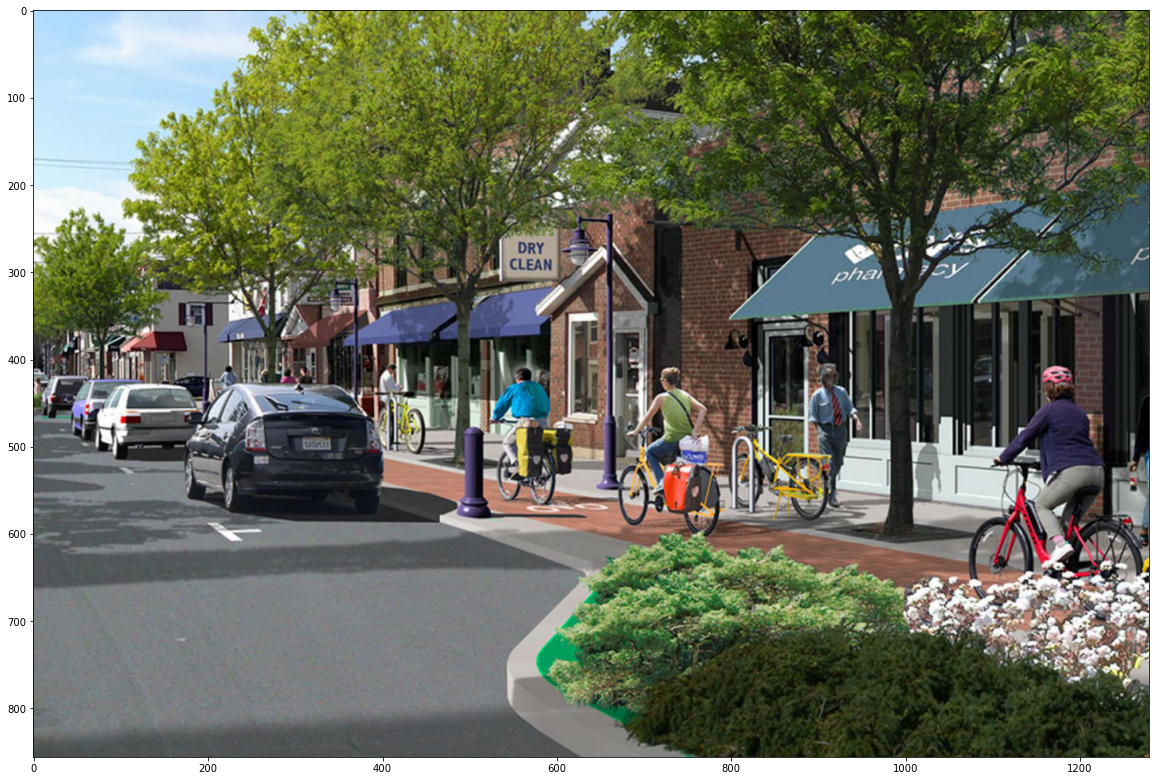

In [3]:
image_url = 'https://www.cnu.org/sites/default/files/styles/public_square_feature_image/public/street-bike-lane-price.jpg?itok=O0PURM5h'
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [46]:
module_handle = 'https://tfhub.dev/tensorflow/efficientdet/lite4/detection/1'
detector = hub.load(module_handle)

In [73]:
def load_img(path):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    pil_image = Image.open(path)
#     pil_image = ImageOps.fit(pil_image, (1024, 1024), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

Found 100 objects.
Inference time:  0.8799962997436523
#7fffd4
#faebd7
#faebd7
#7fffd4
#00ffff
#00ffff
#faebd7
#00ffff
#faebd7
#00ffff


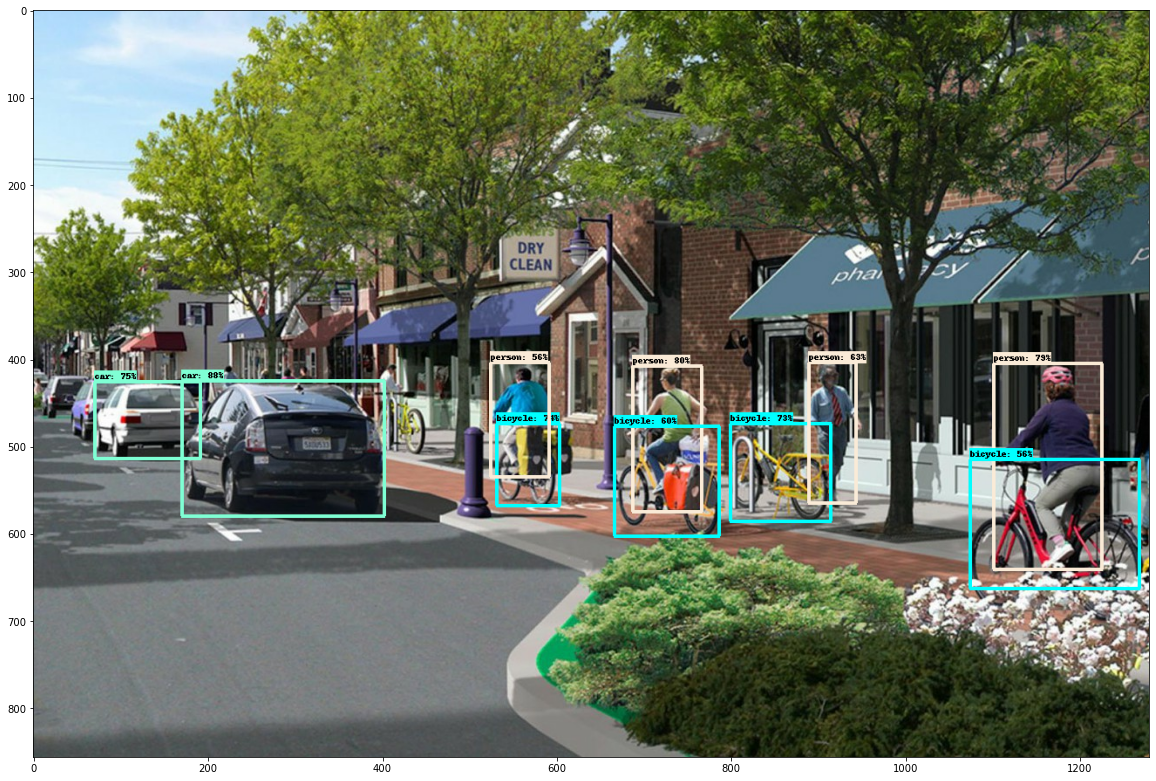

In [100]:
path = downloaded_image_path
img = load_img(path)

converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
start_time = time.time()
boxes, scores, classes, num_detections = detector(converted_img)
boxes = boxes.numpy()
scores = scores.numpy()
classes = classes.numpy()
num_detections = num_detections.numpy()
end_time = time.time()

#     result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % num_detections)
print("Inference time: ", end_time-start_time)

image_with_boxes = draw_boxes(
  img.numpy(), boxes[0],
  classes[0], scores[0])

image = img.numpy()
image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
draw = ImageDraw.Draw(image_pil)
draw.line([(0,0), (600,100)])
np.copyto(image, np.array(image_pil))
display_image(image_with_boxes)